In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from fastai.imports import *
from fastai.vision.all import *
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
import keras
from tensorflow.keras import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# differentiating buildings from food with a CNN

## preparing our dataset

in this notebook we use a subset of the [Food-101 dataset](https://www.kaggle.com/datasets/kmader/food41) and the [House Rooms & Streets Image Dataset](https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset)

first look at some sample images from our datasets

In [2]:
food_path=Path("../input/food41/images")
building_path=Path("../input/house-rooms-streets-image-dataset/kaggle_room_street_data")

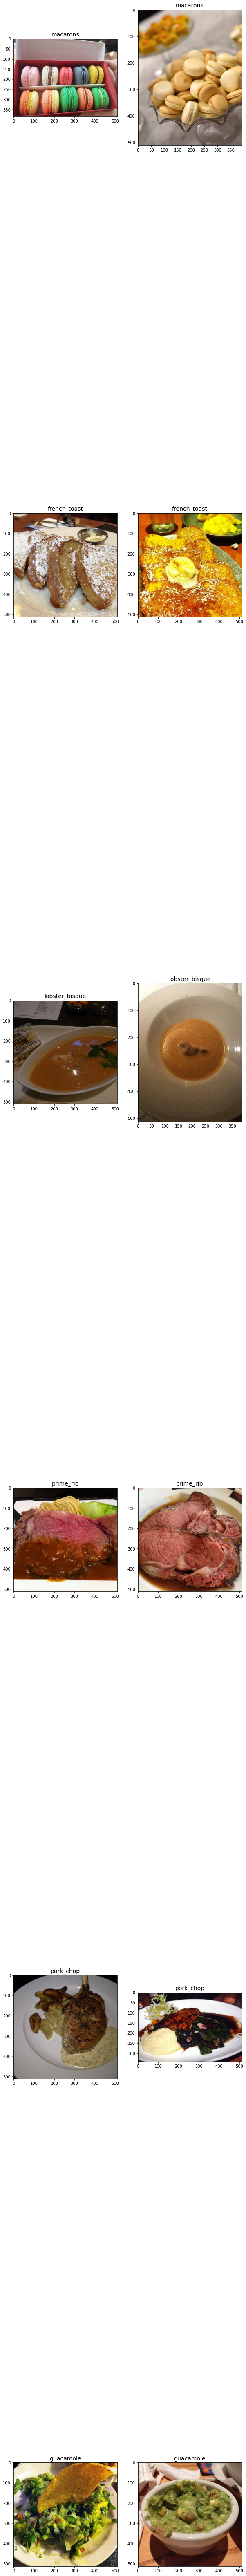

In [3]:
fig, ax = plt.subplots(figsize=(10,128),nrows=6, ncols=2, ) #make a figure to plot
for i,category in enumerate(os.listdir(food_path)): #loop over image categories
    for j, img in enumerate(os.listdir(os.path.join(food_path,category))): # loop over images in each category
        ax[i,j].imshow(PILImage.create(os.path.join(food_path,category,img)),label=category) #plot image
        ax[i,j].set_title(category,fontsize = 14)
        if(j==1):break
    if i==5:break

these were some food images, now let's look at some non-food images

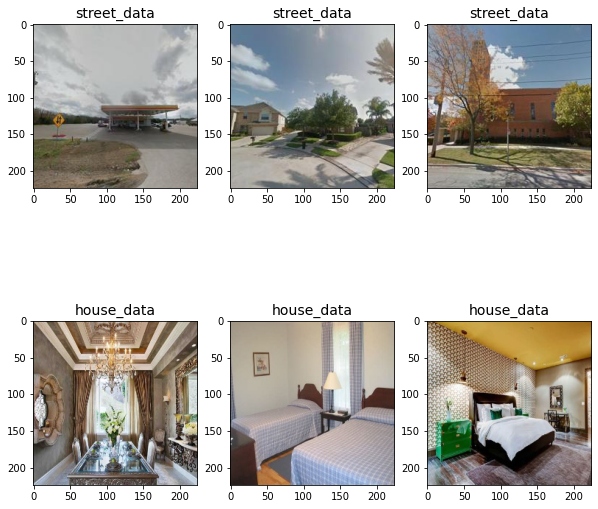

In [4]:
fig, ax = plt.subplots(figsize=(10,10),nrows=2, ncols=3, ) #make a figure to plot
for i,category in enumerate(os.listdir(building_path)): #loop over street data categories
    for j, img in enumerate(os.listdir(os.path.join(building_path,category))): # loop over images in each category
        ax[i,j].imshow(PILImage.create(os.path.join(building_path,category,img)),label=category) #plot image
        ax[i,j].set_title(category,fontsize = 14)
        if(j==2):break


we will make our custom dataset based on the street and food data

In [5]:
num_food_class=len(os.listdir(food_path))
print(f"there are {num_food_class} food classes" )
print(f"there are 2 non-food classes" )

there are 101 food classes
there are 2 non-food classes


we will make a dataset consisting of 505 food images (5 images from each class) and 500 non-food images

In [6]:
dataset_root_path=Path("/kaggle/working/dataset")

we have 101 food classes, to make our model robust and don't give it too much information we will not give it all types of food during training. So in the test set there will be different categories of food that the model has never seen before. We do this because the model has to be robust and recognise food, not specific dishes

In [7]:
i=0
for category_dir, _, images in os.walk(food_path):
    if(i%2):
        for img in images[:20]:
            dest=(dataset_root_path/"train/food") #dest will be /kaggle/working/dataset/food/train
            dest.mkdir(exist_ok=True, parents=True)
            shutil.copy(os.path.join(category_dir, img), dest)
    else:
        for img in images[:10]:
            dest=(dataset_root_path/"test/food") #dest will be /kaggle/working/dataset/food/train
            dest.mkdir(exist_ok=True, parents=True)
            shutil.copy(os.path.join(category_dir, img), dest)
    i+=1

now do the same with the non-food images

In [8]:
for category_dir, _, images in os.walk(building_path):
    for img in images[:510]:
        dest=(dataset_root_path/"train/not_food") #dest will be /kaggle/working/dataset/train/not_food
        dest.mkdir(exist_ok=True, parents=True)
        shutil.copy(os.path.join(category_dir, img), dest)
    for img in images[505:758]:
        dest=(dataset_root_path/"test/not_food") #dest will be /kaggle/working/dataset/test/not_food
        dest.mkdir(exist_ok=True, parents=True)
        shutil.copy(os.path.join(category_dir, img), dest)

our dataset looks something like this

In [9]:
!tree "/kaggle/working/dataset" -d 

/kaggle/working/dataset
├── test
│   ├── food
│   └── not_food
└── train
    ├── food
    └── not_food

6 directories


In [10]:
for dir ,_ ,files in os.walk("/kaggle/working/dataset"):
    if(len(_)==0):
        print(dir + "\tnum of files: "+str(len(files)))

/kaggle/working/dataset/test/food	num of files: 500
/kaggle/working/dataset/test/not_food	num of files: 506
/kaggle/working/dataset/train/food	num of files: 1020
/kaggle/working/dataset/train/not_food	num of files: 1020


now that our dataset is prepared we will load them using **tf.keras.utils.image_dataset_from_directory** utility

In [11]:
data_dir=dataset_root_path/"train"
test_dir=dataset_root_path/"test"

our images have different sizes, we will resize them to 128x128 so they are the same as the tripadvisor dataset

In [12]:
batch_size = 32
img_height = 128
img_width = 128

the labels will be inferred from the directory structure

In [13]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=47,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 2 classes.
Using 1632 files for training.


2022-12-10 19:54:40.574294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 19:54:40.575402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 19:54:40.576578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 19:54:40.577410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 19:54:40.578253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=47,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 2 classes.
Using 408 files for validation.


In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=47,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1006 files belonging to 2 classes.


In [16]:
resize_and_rescale = keras.Sequential([
  layers.Resizing(img_width, img_height),
  layers.Rescaling(1./255)
])

we made ssure to only include relevant augmentations

In [17]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(height_factor=(-0.1, 0.1)),
#     layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    layers.RandomContrast(factor=0.5),
#     keras.layers.RandomBrightness(factor=0.1)
])

take a look at our augmentations

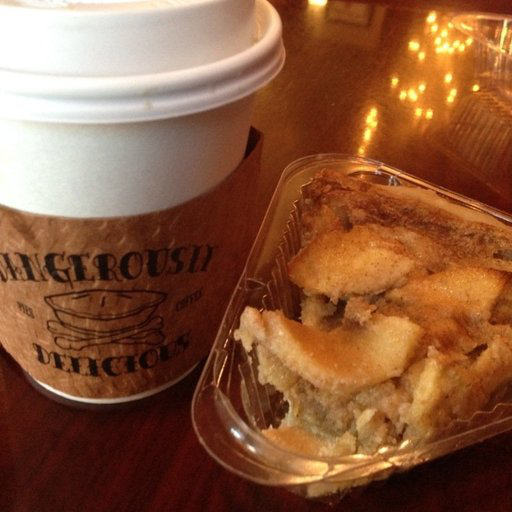

In [18]:
image= PILImage.create("/kaggle/input/food41/images/apple_pie/1014775.jpg")
image

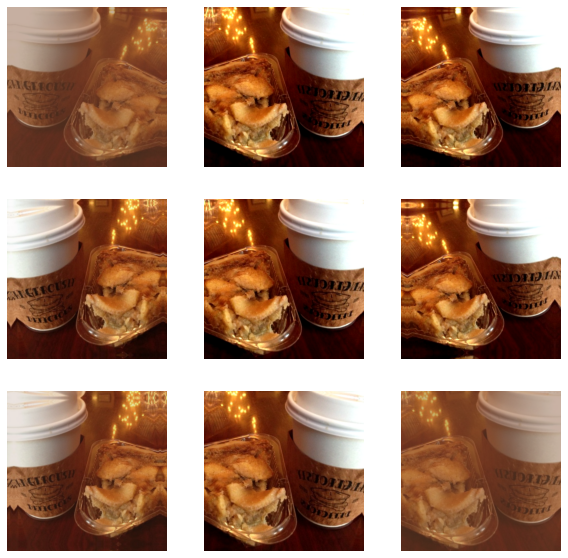

In [19]:
image = tf.cast(tf.expand_dims(image, 0), 'uint8')
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis("off")

In [20]:
def prepare_dataset(ds, batch_size=128, b_shuffle=True,augment=True):
    # transform input data into tf.data
    
    ds = ds.map(map_func = preprocessing ,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # normally you only need to shuffle the training data
    if b_shuffle == True:
        ds = ds.shuffle(len(ds))
    # normally you only need to shuffle the training data
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds



def preprocessing(image, label):
    image = resize_and_rescale(image)
    return image, label

batch_size = 128

train_ds = prepare_dataset(train_ds,augment=True)
val_ds = prepare_dataset(val_ds, b_shuffle = False,augment=False)
test_ds = prepare_dataset(test_ds, b_shuffle = False,augment=False)

we will configure our datasets for performance

In [21]:
# class_names = train_ds.class_names
# print(class_names)
class_names=["food","non_food"]

2022-12-10 19:54:54.918344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


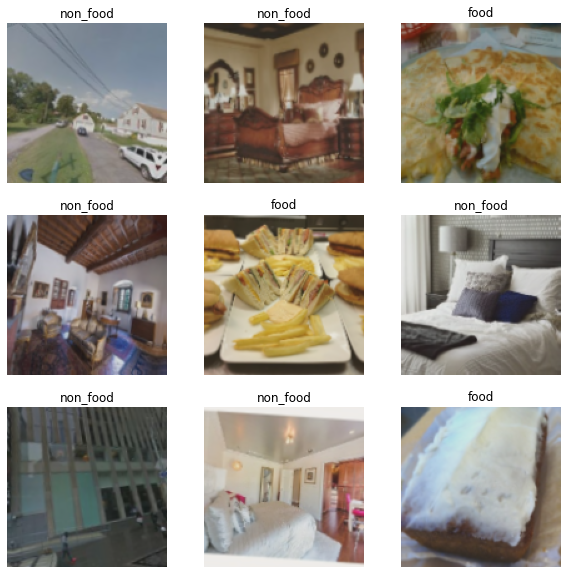

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; 

Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

## making our cutom neural net

## training our model

### building our model

we will make our own custom neural network 

In [29]:
def build_model():
    model=Sequential()
    # model.add(keras.layers.Resizing(img_width, img_height))
    # model.add(keras.layers.Rescaling(1./255))
    model.add(keras.layers.InputLayer((img_width,img_height,3)))
    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('leaky_relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l1(0.001),activation="leaky_relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3),activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('leaky_relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.03)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    #now add our fully connected layers on top
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    #now our output layer
    model.add(keras.layers.Dense(1,activation="sigmoid")) # we will give out a single propability predicting if it is food or not
    # a high number means a high propability of a non-food image
    return model

In [30]:
model_overfit=build_model()
model_overfit.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)       

### first letting our model overfit to see if it is complex enough to distinguish food and non-food

In [31]:
model_overfit.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.005),

#     optimizer=tf.keras.optimizers.Adagrad(0.7),#as stated in the original paper, Adagrad benefits from an initial high lr
#     optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

In [32]:
history = model_overfit.fit(train_ds,
                         validation_data=val_ds,
                         epochs=50,
                         verbose=1)

Epoch 1/50


2022-12-10 19:55:05.852482: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


51/51 [==============================] - 26s 179ms/step - loss: 50.1324 - binary_accuracy: 0.7138 - auc: 0.7367 - val_loss: 68.0182 - val_binary_accuracy: 0.5074 - val_auc: 0.5000
Epoch 2/50
51/51 [==============================] - 10s 154ms/step - loss: 20.5330 - binary_accuracy: 0.7862 - auc: 0.8444 - val_loss: 106.5546 - val_binary_accuracy: 0.5074 - val_auc: 0.5000
Epoch 3/50
51/51 [==============================] - 9s 154ms/step - loss: 9.6593 - binary_accuracy: 0.7708 - auc: 0.8547 - val_loss: 20.1697 - val_binary_accuracy: 0.5074 - val_auc: 0.5000
Epoch 4/50
51/51 [==============================] - 9s 154ms/step - loss: 4.6222 - binary_accuracy: 0.7947 - auc: 0.8549 - val_loss: 45.4185 - val_binary_accuracy: 0.5074 - val_auc: 0.5000
Epoch 5/50
51/51 [==============================] - 9s 146ms/step - loss: 2.6374 - binary_accuracy: 0.8272 - auc: 0.8941 - val_loss: 2.5021 - val_binary_accuracy: 0.4926 - val_auc: 0.8284
Epoch 6/50
51/51 [==============================] - 9s 150ms/s

let's look at the loss curves to see if it overfitted

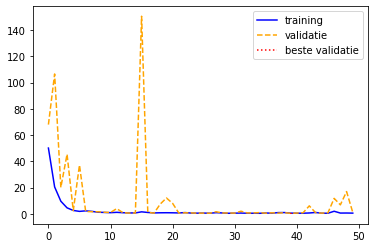

In [33]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.show()

In [34]:
model_overfit.save_weights('model_overfit.h5')

To our surprize it did not overfit, we think this is because of the regularisation and dropout layers and batchnormalisation layers that reduce overfitting

### Training our model (for real this time)

In [35]:

model=build_model()
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.005),
#     optimizer=tf.keras.optimizers.Adagrad(0.7),#as stated in the original paper, Adagrad benefits from an initial high lr
#     optimizer=tf.keras.optimizers.Adam(),#as stated in the original paper, Adagrad benefits from an initial high lr
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

### callbacks

Early stopping will interrupt training when meaningful improvements are no longer observed on the validation data, as this indicates that the model may have reached its peak. The second callback will lower RMSprop's learning rate at appropriate times to try to prevent training from stopping prematurely.

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=1e-4,
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                                     
    patience=10,                                   
    min_delta=1e-4,
    cooldown=0,                               
    verbose=1
) 


### Model fitting

now we can finally start training our model

In [37]:
history = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=100,
                         callbacks=[early_stopping, plateau],
                         verbose=1)

Epoch 1/100
51/51 [==============================] - 11s 155ms/step - loss: 51.5082 - binary_accuracy: 0.7365 - auc_1: 0.7548 - val_loss: 574.0889 - val_binary_accuracy: 0.5074 - val_auc_1: 0.5000
Epoch 2/100
51/51 [==============================] - 10s 151ms/step - loss: 32.1776 - binary_accuracy: 0.7892 - auc_1: 0.8340 - val_loss: 56.0913 - val_binary_accuracy: 0.4926 - val_auc_1: 0.4976
Epoch 3/100
51/51 [==============================] - 9s 153ms/step - loss: 23.5494 - binary_accuracy: 0.8364 - auc_1: 0.8675 - val_loss: 81.4421 - val_binary_accuracy: 0.5074 - val_auc_1: 0.5000
Epoch 4/100
51/51 [==============================] - 10s 162ms/step - loss: 11.8490 - binary_accuracy: 0.8585 - auc_1: 0.9010 - val_loss: 58.1839 - val_binary_accuracy: 0.5270 - val_auc_1: 0.5274
Epoch 5/100
51/51 [==============================] - 10s 161ms/step - loss: 7.2184 - binary_accuracy: 0.8529 - auc_1: 0.9124 - val_loss: 15.9715 - val_binary_accuracy: 0.4926 - val_auc_1: 0.4689
Epoch 6/100
51/51 [==

look at the loss curves

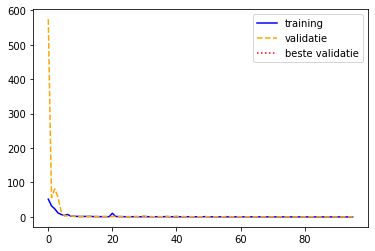

In [38]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.show()

In [39]:
loss, binary_accuracy, auc = model.evaluate(test_ds, verbose=1)
loss, binary_accuracy, auc 

32/32 [==============================] - 2s 63ms/step - loss: 0.1271 - binary_accuracy: 0.9791 - auc_1: 0.9969


(0.12712262570858002, 0.9791252613067627, 0.9968735575675964)

let's look at the ROC curve

In [40]:
scores, labels = [], []
for b, (x_batch, y_batch) in enumerate((test_ds)):
    batch_scores = model.predict(x_batch)
    scores.append(batch_scores)
    labels.append(y_batch)
    
    if b >= len(test_ds):
        break
scores = np.concatenate(scores).squeeze()
labels = np.concatenate(labels).squeeze()

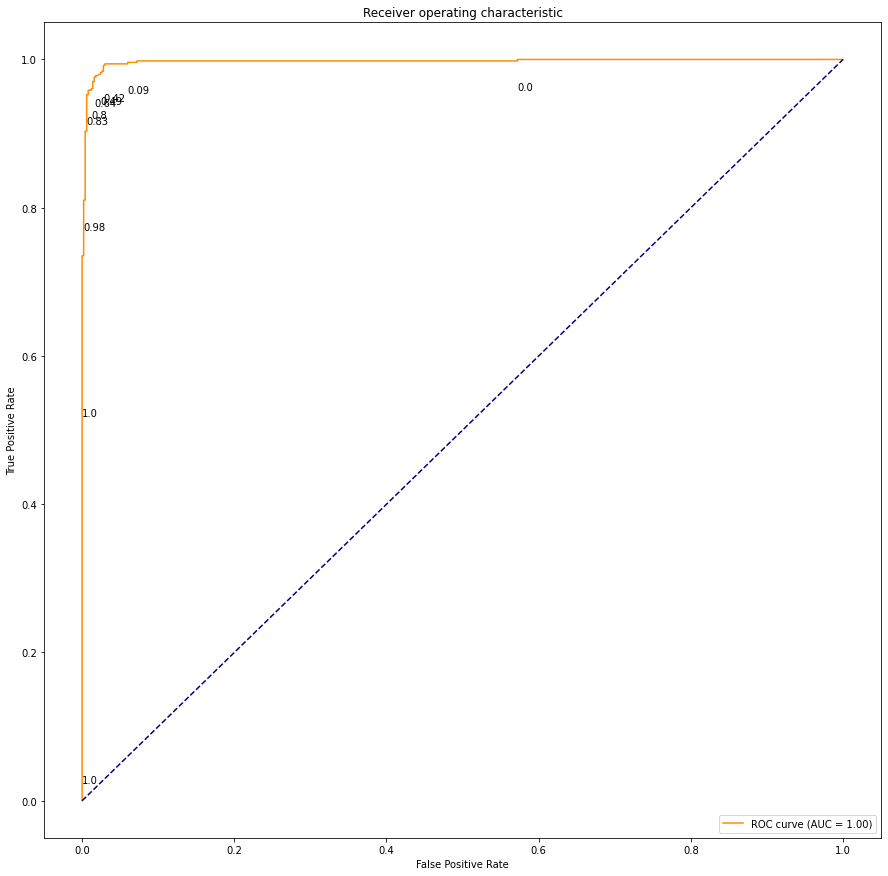

In [41]:
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import roc_curve, auc, accuracy_score


fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
# accuracy = accuracy_score(labels, scores)
plt.figure(figsize=(15, 15))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
i=0
for x, y, txt in zip(fpr, tpr, thresholds):
    i+=1
    if i%4==0:
        plt.annotate(np.round(txt,2), (x, y-0.04))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Our model bacame really good at differentiating buildings and street images from food. We will nog apply this model on our trip advisor dataset to remove the non food images.

In [42]:
model.save_weights('model.h5')